In [1]:
!pip install patchify

In [2]:
import rasterio
import os
import shutil
import numpy as np
from rasterio.plot import show
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import tensorflow as tf

In [3]:
img1 = rasterio.open('/kaggle/input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_nrg.tif')
img2 = rasterio.open('/kaggle/input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_p.tif')

In [4]:
full_img_1 = img1.read()
full_img_2 = img2.read()

In [5]:
new_img2 = ((full_img_2 - full_img_2.min()) * (1/(full_img_2.max() - full_img_2.min()) * 255))
new_img2 = new_img2.reshape(new_img2.shape[1],new_img2.shape[2])

In [6]:
new_img1_b1 = ((full_img_1[0] - full_img_1[0].min()) * (1/(full_img_1[0].max() - full_img_1[0].min()) * 255))
new_img1_b2 = ((full_img_1[1] - full_img_1[1].min()) * (1/(full_img_1[1].max() - full_img_1[1].min()) * 255))
new_img1_b3 = ((full_img_1[2] - full_img_1[2].min()) * (1/(full_img_1[2].max() - full_img_1[2].min()) * 255))
new_img1_3L = np.stack([new_img1_b1/3,new_img1_b2/3,new_img1_b2/3],axis = 2)
new_img1 = np.mean(new_img1_3L, axis=2)

In [7]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
else:
    shutil.rmtree('patches/')
    os.mkdir('patches/')
    
if not os.path.isdir('patches/lr_image/'):
    os.mkdir('patches/lr_image/')
    

large_image = new_img1

patches_img = patchify(large_image, (128, 128), step=128) 

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/lr_image/' + 'image_' +  '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [8]:
if not os.path.isdir('patches/hr_image/'):
    os.mkdir('patches/hr_image/')



large_image = new_img2

patches_img = patchify(large_image, (512, 512), step=512)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/hr_image/' + 'image_' + '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img) 

In [9]:
import os
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten,MaxPooling2D, Lambda
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tensorflow.keras.applications.vgg19 import VGG19
from tqdm import tqdm

In [10]:
lr_list = os.listdir('patches/lr_image/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

lr_images = []
for img in lr_list:
    img_lr =rasterio.open("patches/lr_image/" + img)
    img_lr = img_lr.read()
    img_lr = img_lr.reshape((img_lr.shape[1],img_lr.shape[2],img_lr.shape[0]))
    lr_images.append(img_lr)   

   
hr_images = []
for img in hr_list:
    img_hr =rasterio.open("patches/hr_image/" + img)
    img_hr = img_hr.read()
    img_hr = img_hr.reshape((img_hr.shape[1],img_hr.shape[2],img_hr.shape[0]))
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [11]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.5 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[6].output)

def gray_to_rgb(images):
    return  tf.image.grayscale_to_rgb(images)

def rgb_to_gray(images):
    return  tf.image.rgb_to_grayscale(images)



#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    lambda_layer = tf.keras.layers.Lambda(gray_to_rgb, name="lambda_layer")(gen_img)
    gen_features = vgg(lambda_layer)

    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

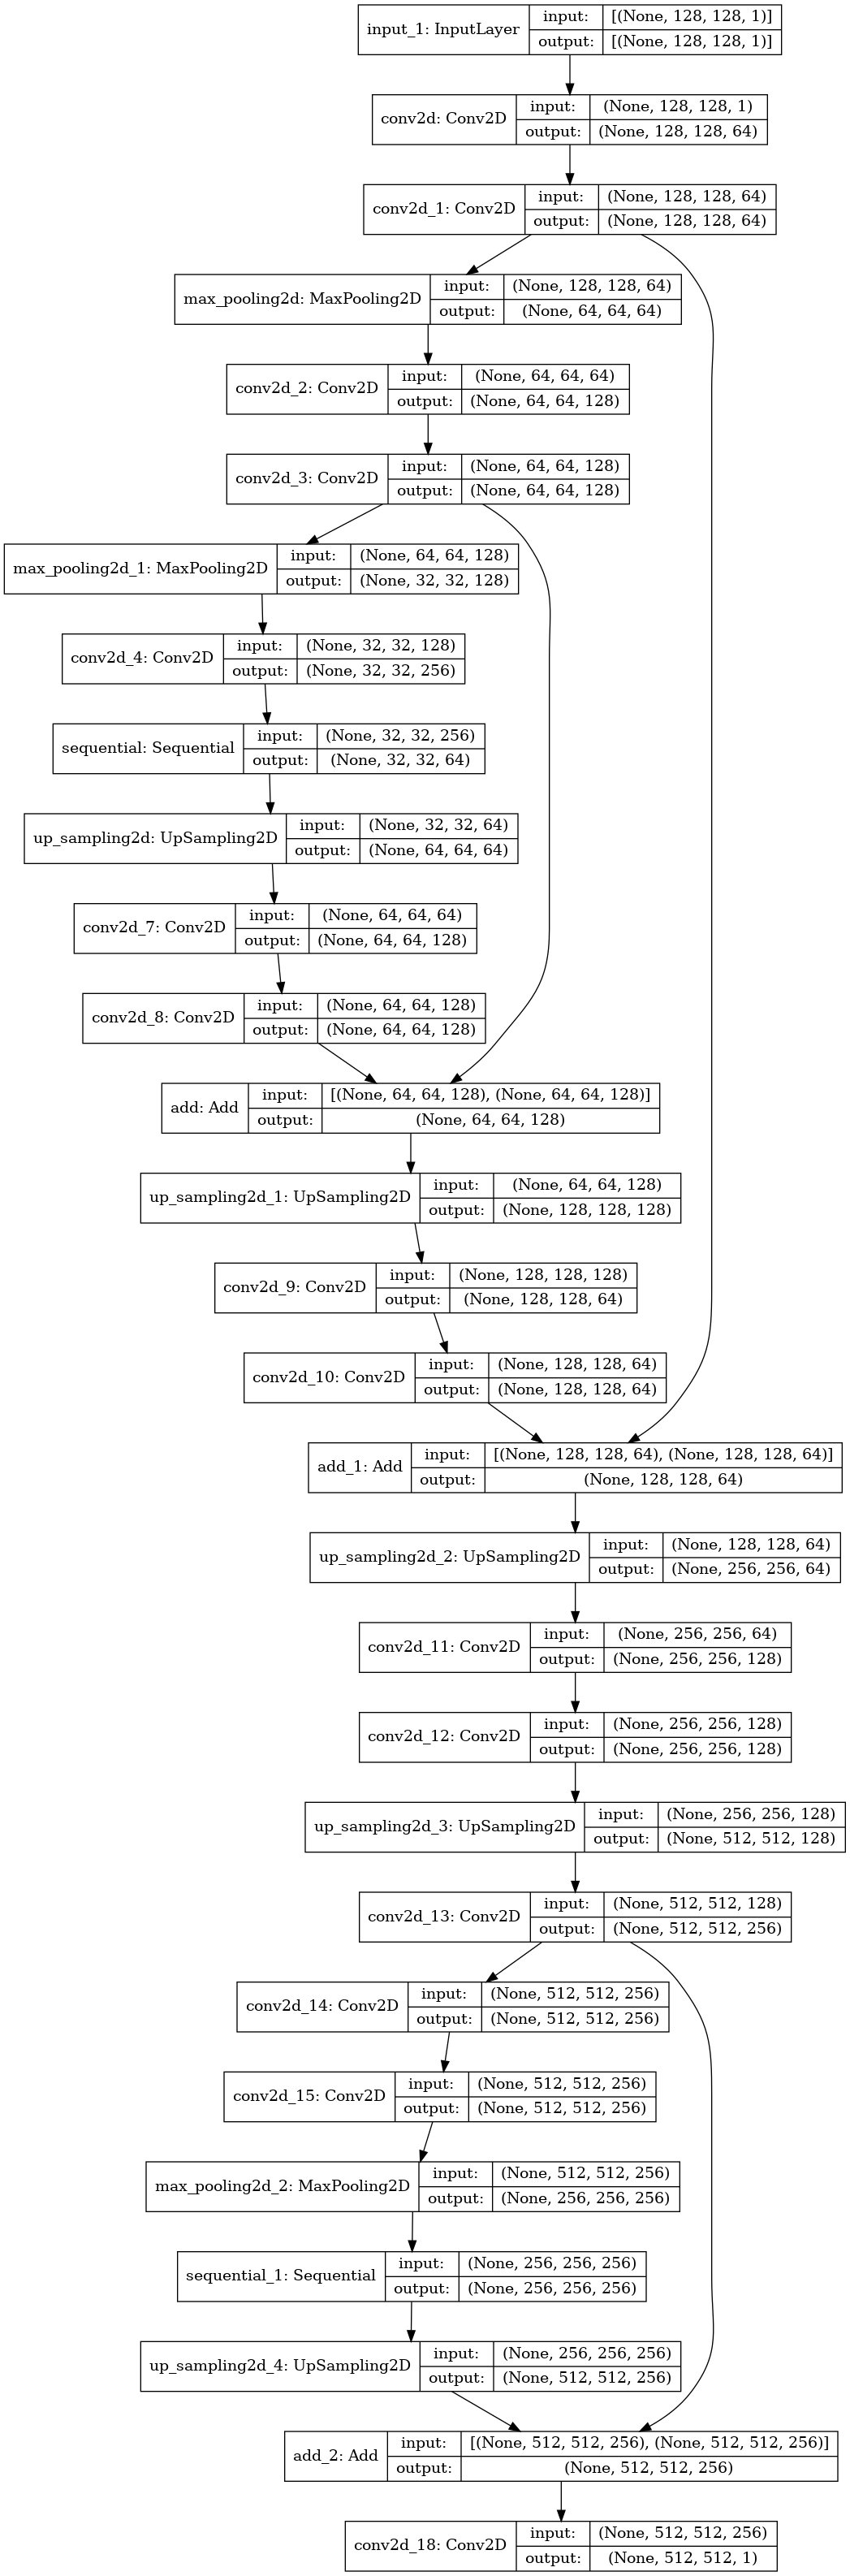

In [12]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

def wt_to_conv64(arr):
    return tf.tile(arr, [1,1,1,16])
def wt_to_conv128(arr):
    return tf.tile(arr, [1,1,1,32])

def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

input_img=Input(shape=(128,128,1))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l5=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l6=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l5)
l7=MaxPooling2D(padding='same')(l6)

l8=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l7)
l8=residual_block_gen()(l8)
l8=UpSampling2D()(l8)
l9=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l10,l6])
l12=UpSampling2D()(l11)
l13=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)

l15=add([l14,l2])

l16=UpSampling2D()(l15)

l17 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l16)
l18 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l17)

l19=UpSampling2D()(l18)

l20 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l19)
l21 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l20)
l22 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l21)
l23=MaxPooling2D(padding='same')(l22)
l24 = residual_block_gen(ch=256)(l23)
l25=UpSampling2D()(l24)
l26=add([l25,l20])


decoder=Conv2D (1,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l26)

#out= tf.keras.filters
autoencoder_residual=Model(input_img,decoder)
plot_model(autoencoder_residual, to_file ='encoder.png',show_shapes=True)

In [14]:
# summarize filter shapes
for layer in autoencoder_residual.layers:
 # check for convolutional layer
 if 'conv' not in layer.name:
     continue
 # get filter weights
 filters, biases = layer.get_weights()
 print(layer.name, filters.shape)

conv2d (3, 3, 1, 64)
conv2d_1 (3, 3, 64, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 128)
conv2d_4 (3, 3, 128, 256)
conv2d_7 (3, 3, 64, 128)
conv2d_8 (3, 3, 128, 128)
conv2d_9 (3, 3, 128, 64)
conv2d_10 (3, 3, 64, 64)
conv2d_11 (3, 3, 64, 128)
conv2d_12 (3, 3, 128, 128)
conv2d_13 (3, 3, 128, 256)
conv2d_14 (3, 3, 256, 256)
conv2d_15 (3, 3, 256, 256)
conv2d_18 (3, 3, 256, 1)


In [13]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape,batch_size = 1)
hr_ip = Input(shape=hr_shape,batch_size = 1)

generator = autoencoder_residual
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((512,512,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 50
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    def gray_to_rgb(images):
        img = tf.convert_to_tensor(images, dtype=tf.int64) 
        return  tf.image.grayscale_to_rgb(img).numpy()

    def rgb_to_gray(images):
        img = tf.convert_to_tensor(images, dtype=tf.int64) 
        return  tf.image.rgb_to_grayscale(img).numpy()
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        #gen_imgs = rgb_to_gray(fake_imgs)
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(gray_to_rgb(hr_imgs))
        
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 1 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  1%|          | 9/882 [10:48<17:17:08, 71.28s/it]

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('../input/aegan-lr-2x/gen_e_15.h5', compile=False)#autoencoder_residual

def rgb_to_gray(images):
    return  tf.image.rgb_to_grayscale(images).numpy()

[X1, X2] = [lr_test, hr_test]
# select random example
ix = np.array([2])
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

cv2.imwrite('SR_IMG_3.tif', gen_image.reshape(256,256,1))

cv2.imwrite('LR_IMG_3.tif', src_image.reshape(128,128,1))

cv2.imwrite('HR_IMG_3.tif', tar_image.reshape(256,256,1))

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(lr_images.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_lr_batches.append(lr_images[start_idx:end_idx])

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('../input/aegan-lr-2x/gen_e_15.h5', compile=False)#autoencoder_residual

src_image = lr_images[2].reshape(1,128,128,1)

# generate image from source
gen_image = generator.predict(src_image)

cv2.imwrite('SR_IMG_3.tif', gen_image.reshape(256,256,1))

cv2.imwrite('LR_IMG_3.tif', src_image.reshape(128,128,1))


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(222)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])


plt.show()